In [1]:
import torch
import matplotlib.pyplot as plt
seed = 42  # Elegimos una semilla de números aleatorios

# Fijamos la semilla en la CPU
torch.manual_seed(seed) #fijamos una semilla para poder reproducir los números aleatorios del cuaderno

### Herencia

El módulo ```nn``` de torch permite heredar otros módulos para anidar redes y realizar cálculos como gradiente estocástico u otros. 

```python
# Definimos una clase en torch que hereda módulos de Torch
class one_layer_net(torch.nn.Module):   
```

In [2]:
torch.nn.Module

torch.nn.modules.module.Module

La segunda inicialización: 
```python
super(one_layer_net, self).__init__()
```
tiene relación con inicializar correctamente la clase ```torch.nn.Module```, para poder heredar de ser necesario atributos de datos como número de capas o modelos (también llamados de arquitecturas) pre-determinados de la librería.

### Modelo de red neuronal lineal

Representa la matriz de pesos sinápticos vista en clases, de la forma: 

\begin{equation}
 \textbf{y} = W\textbf{x} + \textbf{b}
\end{equation}

Por ejemplo: 

In [3]:
linear_layer = torch.nn.Linear(5,3)
parameters_dict = {name: param for name, param in linear_layer.named_parameters()}

In [4]:
parameters_dict

{'weight': Parameter containing:
 tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
         [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281],
         [ 0.3887,  0.0837,  0.3304,  0.0606,  0.2156]], requires_grad=True),
 'bias': Parameter containing:
 tensor([-0.0631,  0.3448,  0.0661], requires_grad=True)}

Esto quiere decir que nuestro modle es inicializado con pesos aleatorios, aparentemente en el intervalo $[-1,1]$
Por ejemplo, dado el vector de entrada: 

$
\mathbf{x}_{\mathtt{input}} = 
\begin{bmatrix}
1 \\
0 \\
1 \\
0 \\
1
\end{bmatrix}
$

El modelo lineal anteriormente generado por la librería ```torch``` recibiría de esta forma el vector: 

$
W \textbf{x} + \textbf{b} = 
\begin{bmatrix}
 0.3419 &  0.3712 & -0.1048 &  0.4108 & -0.0980 \\
 0.0902 & -0.2177 &  0.2626 &  0.3942 & -0.3281 \\
 0.3887 &  0.0837 &  0.3304 &  0.0606 &  0.2156 \\
\end{bmatrix} \begin{bmatrix}
1 \\
0 \\
1 \\
0 \\
1
\end{bmatrix} + \begin{bmatrix} -0.0631 \\ 
0.3448 \\
0.0661 
\end{bmatrix}
$

Lo que equivale a tres neuronas de entrada con cinco parámetros, dada la dimensión del vector de entrada. Y tres "bias" o valores de sesgo, uno para cada neurona artificial. Por lo tanto, en esta parte del código: 

```python
    self.linear_one = torch.nn.Linear(input_size, hidden_neurons)
    self.linear_two = torch.nn.Linear(hidden_neurons, output_size) 
```

Inicializamos dos neuronas artificiales, que tienen dimensiones conformes pues estarán "conectadas" a través de una función sigmoide. Finalmente, el método ```def forward``` definido por: 

```python
    def forward(self, x):
        self.layer_in = self.linear_one(x)
        self.activation = torch.sigmoid(self.layer_in)
        self.layer_out = self.linear_two(self.activation)
        y_pred = torch.sigmoid(self.linear_two(self.activation))
        return y_pred
```

Es nuestro modelo transformando la data de entrada en valores entre $[0,1]$, de la forma: 

$
\textbf{x}_{\mathtt{output}} = \sigma \left(W_{2}\sigma\left( W_{1}\textbf{x}_{\mathtt{input}} + \textbf{b}_{1} \right) + \textbf{b}_{2}\right)
$
Utilizaremos la función de costo logística y un optimizador de gradiente estocástico. 
*Observación*: Explicación general de como yo pienso una red neuronal.

In [5]:
# Definimos una clase en torch que hereda módulos de Torch
class red_de_una_capa(torch.nn.Module):    
    ''' 
        Red neuronal de una capa intermedia.
    '''
    # Constructor o inicializador
    def __init__(self, input_size, hidden_neurons, output_size):
        super(red_de_una_capa, self).__init__()
        # capa de entrada (input layer)
        self.linear_one = torch.nn.Linear(input_size, hidden_neurons)
        # capa oculta (hidden layer)
        self.linear_two = torch.nn.Linear(hidden_neurons, output_size) 
        # podemos definir cada capa como un atributo de la clase
        # por ejemplo, en caso de querer acceder a los pesos para técnicas más avanzadas
        # cómo modificar mediante operaciones los pesos del "presente" y ponderarlos con los del "pasado"
        self.layer_in = None
        self.activation = None
        self.layer_out = None
    # prediction function
    def forward(self, x):
        self.layer_in = self.linear_one(x)
        self.activation = torch.sigmoid(self.layer_in)
        self.layer_out = self.linear_two(self.activation)
        y_pred = torch.sigmoid(self.linear_two(self.activation))
        return y_pred

In [6]:
def funcion_de_costo(y_pred, y):
    '''
        Función de costo logística.
    '''
    out = -1 * torch.mean(y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred))
    return out

Instanciando dos neuronas con entrada de dimensión 1 y salida de dimensión 1. Instanciamos el optimizador.
Donde ```lr = = \alpha``` la tasa de aprendizaje o learning rate. Al optimizador le pasamos los parámetros. 

In [7]:
modelo = red_de_una_capa(1, 2, 1) 
optimizer = torch.optim.SGD(modelo.parameters(), lr=0.01)

Creemos un data set artificial, nuestro modelo va a quere aprender la siguiente función:

In [8]:
X = torch.arange(-30, 30, 0.5).view(-1, 1).type(torch.FloatTensor)
Y = torch.zeros(X.shape[0])
Y[(X[:, 0] <= -10)] = 1.0
Y[(X[:, 0] > -10) & (X[:, 0] < 10)] = 0.5
Y[(X[:, 0] > 10)] = 0

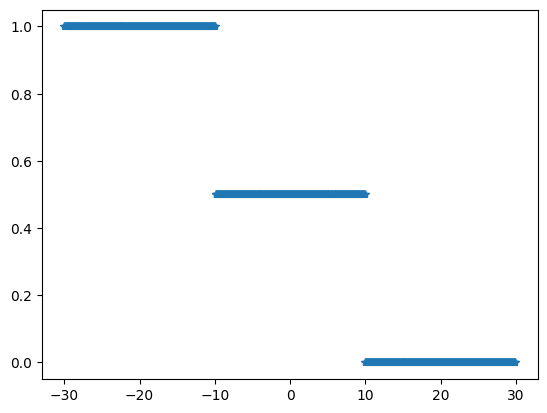

In [9]:
plt.plot(X, Y, '*')
plt.show()

### Comenzamos el entrenamiento

Primero, definimos un loop de entrenamiento. La palabra ```epoch``` significa cuántas veces el modelo verá pasar los datos de entrenamiento, o cuántas veces repetiremos el proceso de entrenamiento para todos los datos.

1000 epochs done!


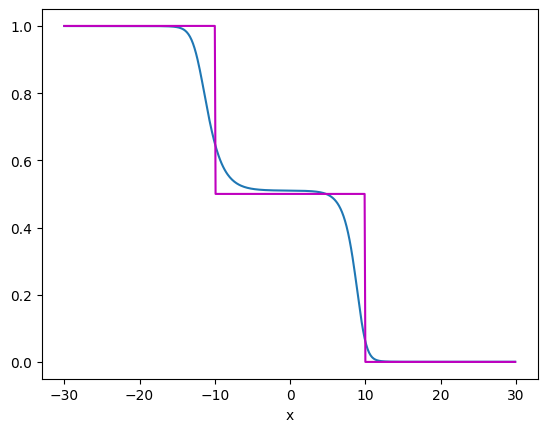

2000 epochs done!


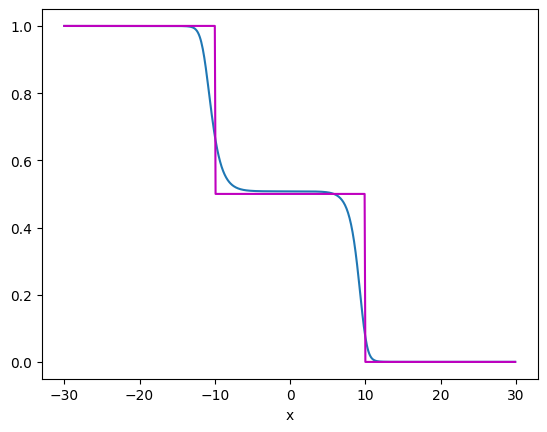

3000 epochs done!


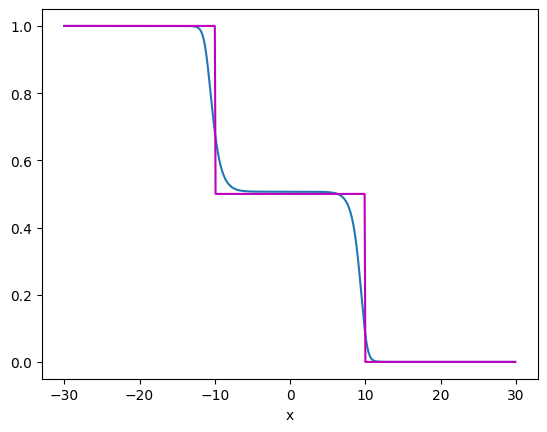

4000 epochs done!


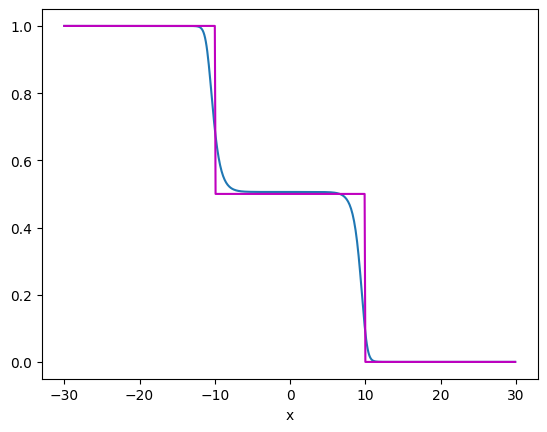

In [10]:
epochs=5000 # repetiremos 5000 veces el proceso de entrenamiento o 5000 épocas.
cost = [] # creamos un vector de costo vacio para posteriormente almancenar el costo por cada época.
total=0 # hacemos comenzar el costo total en cero.
for epoch in range(epochs):
    total=0
    epoch = epoch + 1 # contador de épocas o "repeticiones" del entrenamiento sobre la data de entrenamiento (valga la redundancia)
    for x, y in zip(X, Y):
        yhat = modelo(x)  # pasamos los valores de entrada para generar la salida del modelo
                          # aqui se almacena un grafo con las funciones y transformaciones proporcionadas por el modelo. 
        loss = funcion_de_costo(yhat, y) # calculamos el error cometido por el modelo para ese ejemplo
        loss.backward() # realizamos la retropropagación o backpropagation o cálculo de los gradientes
        optimizer.step() # actualizamos los pesos de la red
        optimizer.zero_grad() # borramos los gradientes calculados para volver a calcularlos en la proxima iteracion
        # calculamos la perdida de un ejemplo
        total+=loss.item() # vamos sumando el costo para cada ejemplo de entrenamiento
    cost.append(total) # guardamos la suma total del costo
    if epoch % 1000 == 0: # cada 1000 épocas
        print(str(epoch)+ " " + "epochs done!") # visualizamos los resultados
        # gráficos 
        plt.plot(X.numpy(), modelo(X).detach().numpy()) # en el segundo argumento, calculamos un forward pass de toda la data
                                                        # desactivamos la conexión con el grafo de gradientes para que no
                                                        # se rastreen mas cambios de retropropagacion
                                                        # transformamos los vectores de pytorch en numpy arrays
        plt.plot(X.numpy(), Y.numpy(), 'm')
        plt.xlabel('x')
        plt.show()

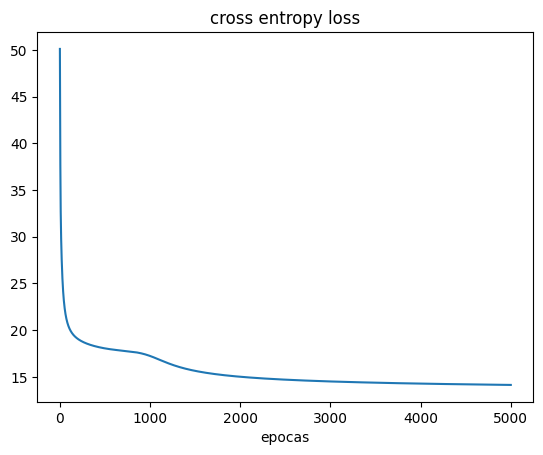

In [ ]:
# Funcion de costo
plt.plot(cost)
plt.xlabel('epocas')
plt.title('cross entropy loss')
plt.show()

### Red Multi Capa

In [ ]:
class RedMulticapa(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(RedMulticapa, self).__init__()
        self.hidden_layers = torch.nn.ModuleList()
        
        # Capa de entrada
        self.hidden_layers.append(torch.nn.Linear(input_size, hidden_sizes[0]))
        
        # Capas ocultas
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        # Capa de salida
        self.output_layer = torch.nn.Linear(hidden_sizes[-1], output_size)
        
    def forward(self, x):
        # Propagación hacia adelante a través de capas ocultas
        for layer in self.hidden_layers:
            x = torch.sigmoid(layer(x))
        
        # Capa de salida
        y_pred = torch.sigmoid(self.output_layer(x))
        
        return y_pred

1000 epochs done!


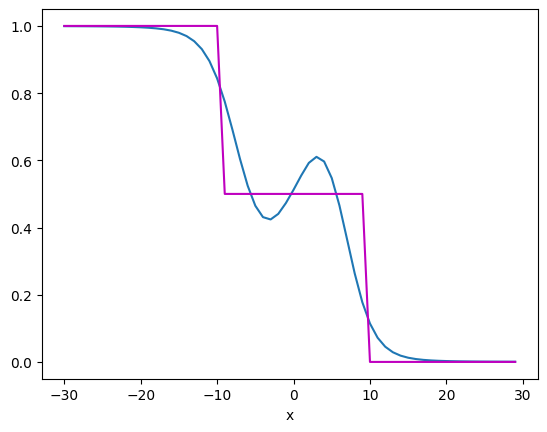

2000 epochs done!


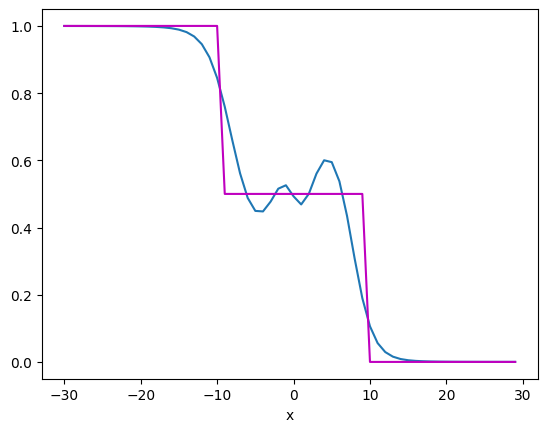

3000 epochs done!


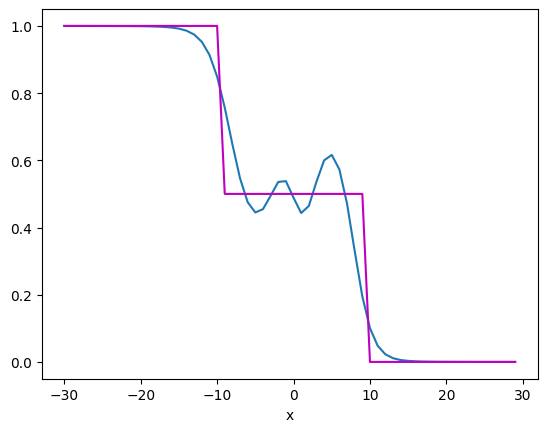

4000 epochs done!


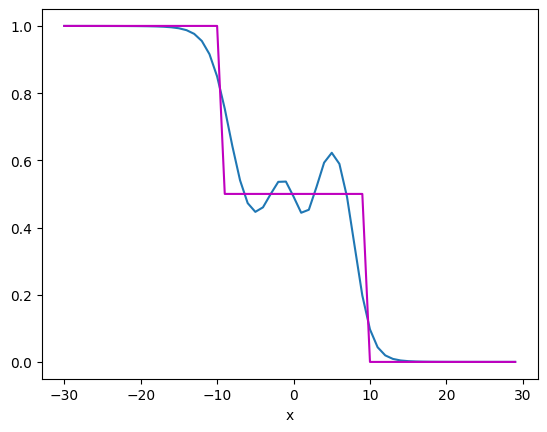

5000 epochs done!


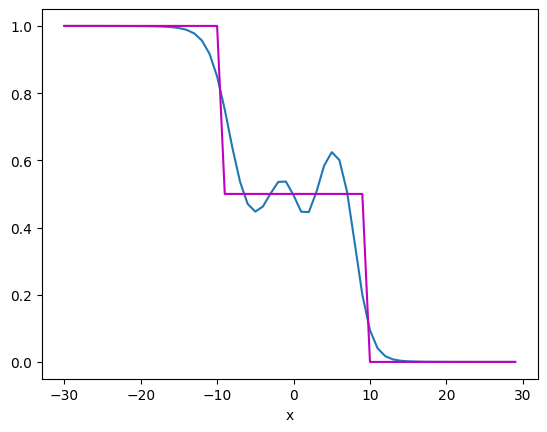

In [ ]:
# Datos de entrenamiento y prueba (ejemplo)
input_size = 1
hidden_sizes = [64, 32]  # Número de neuronas en cada capa oculta
output_size = 1

# Crear una instancia de la red
red_multicapa = RedMulticapa(input_size, hidden_sizes, output_size)

# Definir una función de pérdida (criterio) y un optimizador
optimizer = torch.optim.SGD(red_multicapa.parameters(), lr=0.01)  # Descenso de gradiente estocástico
epochs=5000 # repetiremos 5000 veces el proceso de entrenamiento o 5000 épocas.
cost = [] # creamos un vector de costo vacio para posteriormente almancenar el costo por cada época.
total=0 # hacemos comenzar el costo total en cero.
for epoch in range(epochs):
    total=0
    epoch = epoch + 1 # contador de épocas o "repeticiones" del entrenamiento sobre la data de entrenamiento (valga la redundancia)
    for x, y in zip(X, Y):
        yhat = red_multicapa(x)  # pasamos los valores de entrada para generar la salida del modelo
                          # aqui se almacena un grafo con las funciones y transformaciones proporcionadas por el modelo. 
        loss = funcion_de_costo(yhat, y) # calculamos el error cometido por el modelo para ese ejemplo
        loss.backward() # realizamos la retropropagación o backpropagation o cálculo de los gradientes
        optimizer.step() # actualizamos los pesos de la red
        optimizer.zero_grad() # borramos los gradientes calculados para volver a calcularlos en la proxima iteracion
        # calculamos la perdida de un ejemplo
        total+=loss.item() # vamos sumando el costo para cada ejemplo de entrenamiento
    cost.append(total) # guardamos la suma total del costo
    if epoch % 1000 == 0: # cada 1000 épocas
        print(str(epoch)+ " " + "epochs done!") # visualizamos los resultados
        # gráficos 
        plt.plot(X.numpy(), red_multicapa(X).detach().numpy()) # en el segundo argumento, calculamos un forward pass de toda la data
                                                        # desactivamos la conexión con el grafo de gradientes para que no
                                                        # se rastreen mas cambios de retropropagacion
                                                        # transformamos los vectores de pytorch en numpy arrays
        plt.plot(X.numpy(), Y.numpy(), 'm')
        plt.xlabel('x')
        plt.show()

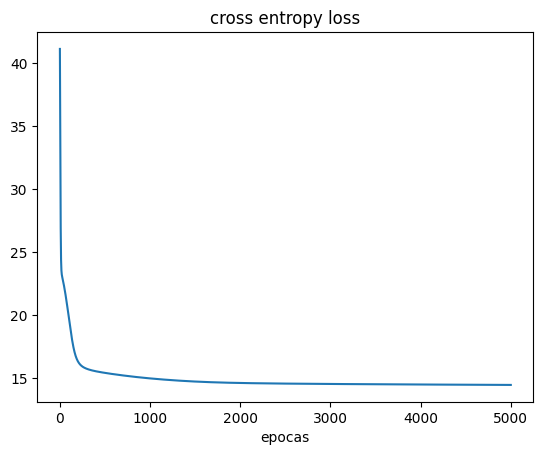

In [ ]:
# Funcion de costo
plt.plot(cost)
plt.xlabel('epocas')
plt.title('cross entropy loss')
plt.show()